# EventSeg-demo

### Imports

In [1]:
from utils import *
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import LeaveOneOut, KFold, train_test_split

from brainiak.eventseg.event import EventSegment

import matplotlib.pyplot as plt
%matplotlib inline

/Users/lendlab/opt/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
# only run once
!cp ./hmm-fmri/hmm_fmri.py .

In [3]:
from hmm_fmri import SimSimpData, Dataset

### Make a data directory

In [3]:
!mkdir data

### Download data

> This will take > 15 seconds

In [6]:
download_data("data")

Successful download in 	 data


### Load data

In [7]:
D = load_data(path="data", dataset="sherlock")

Access variables like 
 D["BOLD"] 
 D["coords"] 
 D["human_bounds"]


### Look at some BOLD data

Text(0, 0.5, 'Regions')

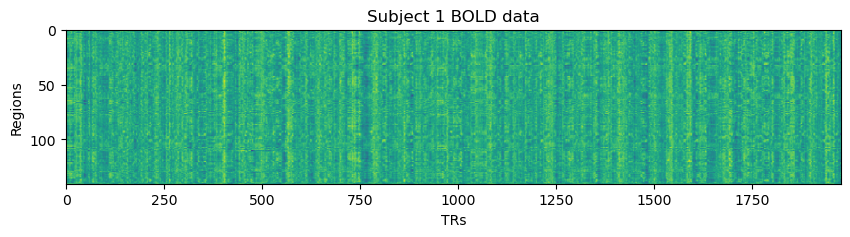

In [13]:
plt.figure(figsize=(10, 2))
plt.imshow(D["BOLD"][:, :, 1], aspect='auto')
plt.title('Subject 1 BOLD data')
plt.xlabel("TRs")
plt.ylabel("Regions")

### Formal model fitting

This is the nested cross validation skeleton

In [25]:
# get some variables
nReg, nTRs, nSubs = np.shape(D['BOLD'])

# nested CV constants
n_splits_inner = 4
subj_id_all = np.array([i for i in range(nSubs)])

# set up outer loop loo structure
loo_outer = LeaveOneOut()
loo_outer.get_n_splits(subj_id_all)
for subj_id_train_outer, subj_id_test_outer in loo_outer.split(subj_id_all):
    print("Outer:\tTrain:", subj_id_train_outer, "Test:", subj_id_test_outer)
    
    # set up inner loop loo structure
    subj_id_all_inner = subj_id_all[subj_id_train_outer]
    kf = KFold(n_splits=n_splits_inner)
    kf.get_n_splits(subj_id_train_outer)
    
    print('Inner:')
    for subj_id_train_inner, subj_id_test_inner in kf.split(subj_id_all_inner):
        # inplace update the ids w.r.t. to the inner training set
        subj_id_train_inner = subj_id_all_inner[subj_id_train_inner]
        subj_id_test_inner = subj_id_all_inner[subj_id_test_inner]
        print("-Train:", subj_id_train_inner, "Test:", subj_id_test_inner, ', now try different k...')
    print()

Outer:	Train: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] Test: [0]
Inner:
-Train: [ 5  6  7  8  9 10 11 12 13 14 15 16] Test: [1 2 3 4] , now try different k...
-Train: [ 1  2  3  4  9 10 11 12 13 14 15 16] Test: [5 6 7 8] , now try different k...
-Train: [ 1  2  3  4  5  6  7  8 13 14 15 16] Test: [ 9 10 11 12] , now try different k...
-Train: [ 1  2  3  4  5  6  7  8  9 10 11 12] Test: [13 14 15 16] , now try different k...

Outer:	Train: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] Test: [1]
Inner:
-Train: [ 5  6  7  8  9 10 11 12 13 14 15 16] Test: [0 2 3 4] , now try different k...
-Train: [ 0  2  3  4  9 10 11 12 13 14 15 16] Test: [5 6 7 8] , now try different k...
-Train: [ 0  2  3  4  5  6  7  8 13 14 15 16] Test: [ 9 10 11 12] , now try different k...
-Train: [ 0  2  3  4  5  6  7  8  9 10 11 12] Test: [13 14 15 16] , now try different k...

Outer:	Train: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16] Test: [2]
Inner:
-Train: [ 5  6  7  8  9 10 11 12 13 14 15 1

###  Generate some fake data with `hmm-fmri`

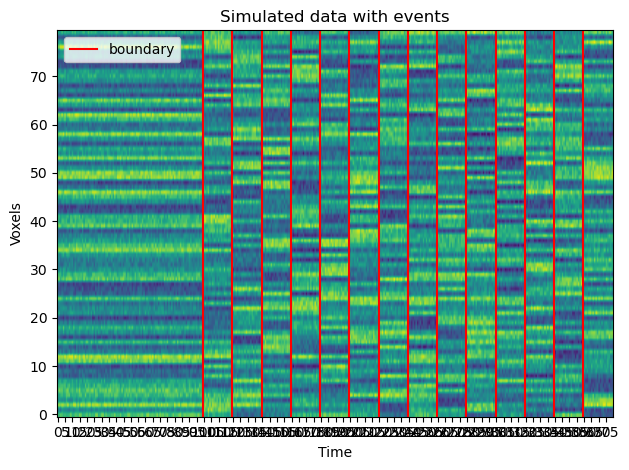

In [4]:
# create a single data
simpdat = SimSimpData(n_events=15, size=(80, 100), noise=0.3, skew=True, skewf=20).data()

# plot
simpdat.plot()

### Make an entire dataset with `hmm-fmri`

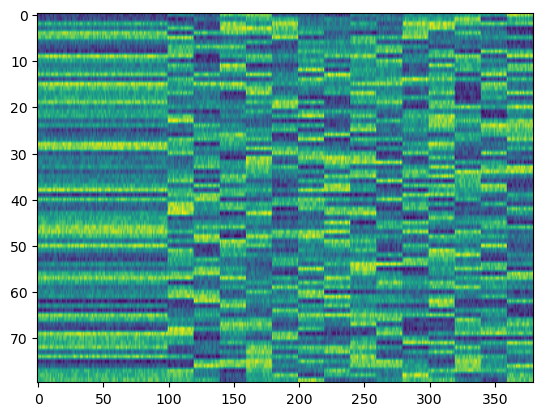

In [27]:
# create dataset
D = Dataset(base=simpdat, n=40).make_dataset() # dataset with 40 individuals

# plot
dset = np.delete(D.dataset, 0, axis=0)
plt.imshow(dset[0].T, aspect='auto') # first participant data

### Inner loop: Tune `k`

> This is computationally intensive and is scaled by `k` and the training data.

> It is recommended to connect to a remote server or HPC.

In [32]:
# parse subjects
nSubs = len(D.dataset) - 1
subj_id_test = 0
subj_id_val = 1 
subj_id_train = [
    subj_id for subj_id in range(nSubs) 
    if subj_id not in [subj_id_test, subj_id_val]
]

BOLD_train, BOLD_val_test = train_test_split(dset, test_size=0.4, random_state=42)
BOLD_val, BOLD_test = train_test_split(BOLD_val_test, test_size=0.5, random_state=42) 


# get some k's (adjust as needed)
k_vals = np.arange(1, 15, 1)

# track log-likelihoods
log_likely = []

# fit
for k, j in zip(k_vals, BOLD_train):
    # Fit HMM on training data
    HMM = EventSegment(n_events=k)
    HMM.fit(j)

    # collect LL
    ll = HMM.ll_
    log_likely.append(ll)

# Find the best k based on validation set
# best_k_index = np.argmax(log_likely)
# best_k = k_vals[best_k_index]


print('Whole dataset:\t', np.shape(dset))
print('Training set:\t', np.shape(BOLD_train))
print('Tune set:\t', np.shape(BOLD_val))
print('Test set:\t', np.shape(BOLD_test))

print(subj_id_train)
print(subj_id_val)
print(subj_id_test)

Whole dataset:	 (39,)
Training set:	 (23,)
Tune set:	 (8,)
Test set:	 (8,)
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
1
0


### Plot log-likelyhood

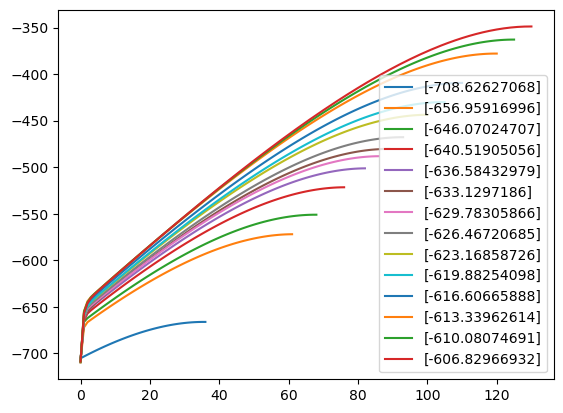

In [42]:
[plt.plot(i) for i in log_likely];
[plt.legend(i) for i in log_likely]